In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid, save_image
from torchvision import transforms, datasets, models
from torchsummary import summary
import time
import copy
import enum
import random; random.seed(42)
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
import os
import sys
from deepbrain import Extractor


np.seterr(all='ignore') 

from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)

landmarks = np.load('landmarks.npy')

transform = Compose([
    RescaleIntensity((0, 1)),  
    HistogramStandardization({'mri': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    ToCanonical(),
    Resample((1, 1, 1)),
    CropOrPad((224, 224, 224)),

])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'AD': 1, 'MCI': 2}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2]):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV. 
            labels (list): labels to retrieve. 'CN': 0, 'AD': 1, MCI': 2
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 224

        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)
        
        
        try:
            
            subject = torchio.Subject({'mri': torchio.Image(imagepath, torchio.INTENSITY)})
            transformed_subject = transform(subject)

            #         create imgbatch with three different perspectives
            imgbatch = []


            imgdata = transformed_subject['mri'].data.reshape(imgsize, imgsize, imgsize).data


            imgdata1 = imgdata[imgsize//2, :, :]
            imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
            imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))

            imgdata2 = imgdata[:, imgsize//2, :]
            imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
            imgbatch.append(imgdata2.reshape(3, imgsize, imgsize))

            imgdata3 = imgdata[:, :, 140]
            imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
            imgbatch.append(imgdata3.reshape(3, imgsize, imgsize))

            sample = (imgbatch, torch.tensor(label))
            return sample
        
        except:
            pass

datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])



If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

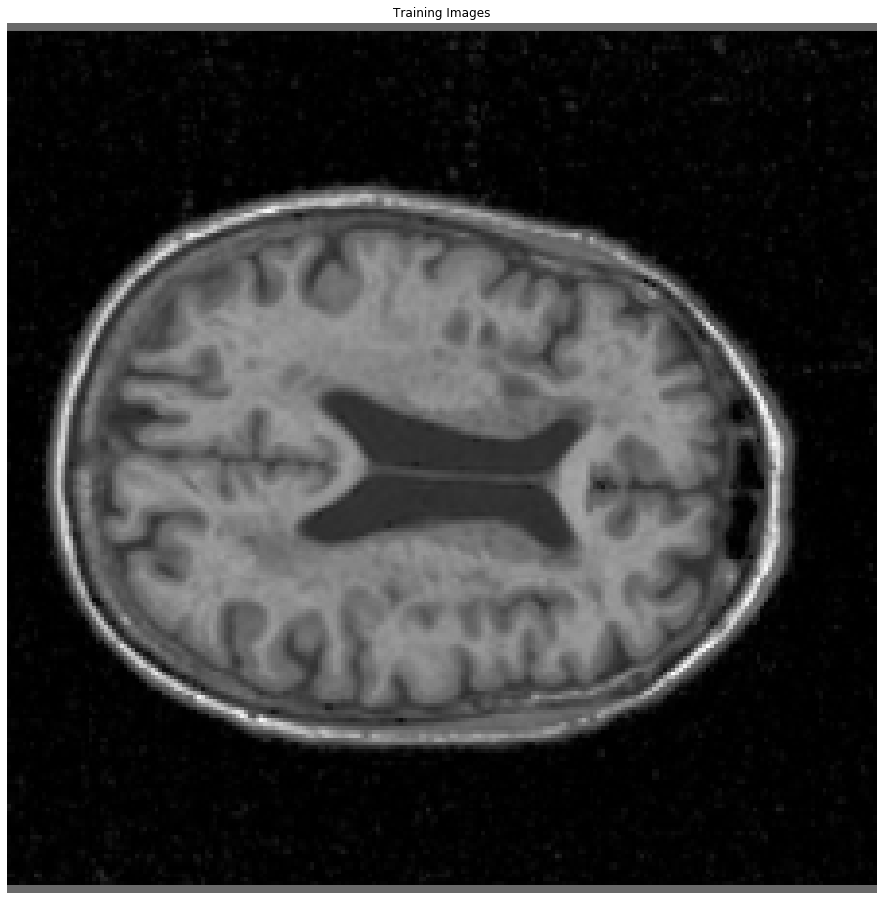

In [4]:
import torchvision
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dataset, batch_size=1,shuffle=True, num_workers=4)
batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(
    torchvision.utils.make_grid(batch[0][2], padding=2, normalize=True),(1,2,0)))
plt.show()

In [5]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'AD': 1, 'MCI': 2}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV. 
            labels (list): labels to retrieve. 'CN': 0, 'AD': 1, MCI': 2
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 224

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)

        
        #         create imgbatch with three different perspectives
        imgbatch = []
        
        imgdata = nib.load(imagepath).get_fdata()

        if self.transform:
            imgdata = self.transform(imgdata)
            
        imgdata1 = cv2.resize(imgdata[imgdata.shape[0]//2-12, :, :], (imgsize, imgsize))
        imgdata1 = torch.from_numpy(imgdata1)
        imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        imgdata2 = cv2.resize(imgdata[:, imgdata.shape[1]//2, :], (imgsize, imgsize))
        imgdata2 = torch.from_numpy(imgdata2)
        imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
        imgbatch.append(imgdata2.reshape(3, imgsize, imgsize))
        
        imgdata3 = cv2.resize(imgdata[:, :, imgdata.shape[2]//2], (imgsize, imgsize))
        imgdata3 = torch.from_numpy(imgdata3)
        imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
        imgbatch.append(imgdata3.reshape(3, imgsize, imgsize))
        
        sample = (imgbatch, torch.tensor(label))
        return sample


datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])

data = [sample for sample in tqdm(dataset)]
torch.save(data, '../../datasets/224dataset.pt')

In [6]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid, save_image
from torchvision import transforms, datasets, models
from torchsummary import summary
import time
import copy
import enum
import random; random.seed(42)
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
import os
import sys
from deepbrain import Extractor


np.seterr(all='ignore') 

from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)

landmarks = np.load('landmarks.npy')

transform = Compose([
    RescaleIntensity((0, 1)),  
    HistogramStandardization({'mri': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    ToCanonical(),
    Resample((1, 1, 1)),
    CropOrPad((224, 224, 224)),

])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'AD': 1, 'MCI': 2}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2]):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV. 
            labels (list): labels to retrieve. 'CN': 0, 'AD': 1, MCI': 2
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 224

        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)
        
        
        try:
            
            subject = torchio.Subject({'mri': torchio.Image(imagepath, torchio.INTENSITY)})
            transformed_subject = transform(subject)

            #         create imgbatch with three different perspectives
            imgbatch = []


            imgdata = transformed_subject['mri'].data.reshape(imgsize, imgsize, imgsize).data


            imgdata1 = imgdata[imgsize//2, :, :]
            imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
            imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))

            imgdata2 = imgdata[:, imgsize//2, :]
            imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
            imgbatch.append(imgdata2.reshape(3, imgsize, imgsize))

            imgdata3 = imgdata[:, :, imgsize//2]
            imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
            imgbatch.append(imgdata3.reshape(3, imgsize, imgsize))

            sample = (imgbatch, torch.tensor(label))
            return sample
        
        except:
            pass

datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])

data = [sample for sample in tqdm(dataset)]
torch.save(data, '../../datasets/224torchiodataset.pt')



If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.